# Benchmark C1.2: Coupled problems - Water uptake by a static root system
by Daniel Leitner, Andrea Schnepf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.interpolate import interp1d
import csv
from pathlib import Path
import os
from van_genuchten import *

Todo

text, split (a) and (b)



## Comparison of numerical solutions to reference solution

We compare different numerical codes to the explicit high resolution numerical solution.

We compare different numerical codes by solving the benchmarking problems. In addition, we provide links to Jupyter Notebooks that describe the numerical implementation of a benchmark problem in a specific code should they be available in the subfolder 'M3.2 Model descriptions'

### Result data format of C1.2

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(14,14)) 

#reference solution
data = np.loadtxt("C1.2a Numerical results/"+"reference.csv",delimiter=';')  
t_a=data[0,:] 
y_a=data[1,:] 
cumy_a = integrate.cumtrapz(data[1,:],data[0,:],initial=0)
ax[0,0].plot(t_a,y_a,'r*')
ax[1,0].plot(t_a,integrate.cumtrapz(y_a,t_a,initial=0),'r:')  

l, nrmsea, namea =["Reference"], [], []
for dirname, dirnames, filenames in os.walk('C1.2a Numerical results/.'):
    filenames.sort()
    for i,f in enumerate(filenames):
        try:
            if f != "reference":
                l.append(f)
                data = np.loadtxt("C1.2a Numerical results/"+f,delimiter=';')  
                ax[0,0].plot(data[0,:],data[1,:],col[i])
                ax[1,0].plot(data[0,:],integrate.cumtrapz(data[1,:],data[0,:],initial=0), color = col[i+1])                  
                interp = interp1d(data[0,:], integrate.cumtrapz(data[1,:],data[0,:],initial=0),  kind='linear', fill_value='extrapolate', bounds_error =False ) 
                cumy_n = interp(t_a) 
                nrmsea.append(nRMSE(cumy_a, cumy_n))
                namea.append(f)
        except Exception as ex:
            print("Something went wrong with file "+f)    
            raise

            ax[0,0].set_xlabel("time [d]")  
ax[0,0].set_ylabel("actual transpiration [cm/d]")  
ax[0,0].legend(l) 
ax[0,0].title.set_text("C1.2a (constant root hydraulic properties)")
ax[0,0].set_xlim(0,3)
ax[1,0].set_xlabel("time [d]")  
ax[1,0].set_ylabel("cumT [cm]")  
ax[1,0].legend(l) 
ax[1,0].set_xlim(0,3)



plt.savefig('c12_results.png', dpi=300, bbox_inches = "tight")
plt.show() 

ValueError: Invalid RGBA argument: 'b-'

ValueError: Invalid RGBA argument: 'b-'

<Figure size 1008x1008 with 4 Axes>

In [3]:
# function definitions
# normalized root mean squared error
def nRMSE(y_ana, y_num):
    assert len(y_ana)==len(y_num), "number of analytical solutions y_ana must equalt number of numerical solutions y_num"
    n = len(y_ana)
    rmse = np.sqrt(np.sum(np.square(y_ana-y_num))/n)
    return rmse/np.abs(np.mean(y_ana)) 

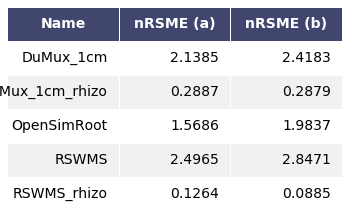

In [4]:
import pandas as pd 

data_ = np.array([namea, nrmsea, nrmseb]); #data_b = pandas.concat([data_, additional], axis=1)
data_ = np.array(data_.transpose())

df = pd.DataFrame(data_, columns = ['Name','nRSME (a)','nRSME (b)'] ) # Create the pandas DataFrame 
df['nRSME (a)'] = df['nRSME (a)'].astype(float)
df['nRSME (a)'] = df['nRSME (a)'].map('{:,.4f}'.format)
df['nRSME (b)'] = df['nRSME (b)'].astype(float)
df['nRSME (b)'] = df['nRSME (b)'].map('{:,.4f}'.format)
# print dataframe. 
df.style.set_table_styles(
[{'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#eee')]}, 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 {'selector': 'th',
  'props': [('background', '#606060'), 
            ('color', 'white'),
            ('font-family', 'verdana')]},
 {'selector': 'td',
  'props': [('font-family', 'verdana')]},
]
).hide_index()

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(df, header_columns=0, col_width=2.0)
fig.savefig("table_c12.png")
